<center>

*******************************************************************************************
    
### Motion Tracking in Video Files with ALphaPose


##### 21 February 2025

##### Juan Ignacio Mendoza Garay  

*******************************************************************************************

</center>

##### INFORMATION:

* This program extracts one point of the body (in this demonstration the nose), for every tracked person in the picture. Then, it gets rid of extraneous data, interpolates missing data, and rearranges the tabular data. The resulting table has columns {p1_x,p1_y,p2_x,p2_y,...} where p is a tracked person from left to right, and {x,y} are horizontal and vertical coordinates of the point.

* Tested using:

    * AlphaPose
        * Alpha_Pose fork: https://github.com/juigmend/Alpha_Pose
    * Python 3.11
    * Windows 11 operating system
    * Intel 64-bit CPU
>
* Dependencies:

    * cython_bbox:
        1) install Desktop Development with C++ from the Visual Studio Installer
        2) type to command prompt: \
           set DISTUTILS_USE_SDK=1 
        3) install cython_bbox (e.g., using pip, conda, or other method)
    * Other packages might be prompted for installation.
>
* Instructions:

    Edit the values indicated with an arrow like this: <---  
    Comment/uncomment or change values as suggested by the comments.  
    Run the program, close your eyes and hope for the best.

* To improve the quality of tracking these can be tried:

    *   use video with higher resolution if available
    *   change parameters in detector/yolo_cfg.py, start by increasing INP_DIM   
    *   use another detector (e.g., yolox-x, yolox-l)
    *   use another pretrained model
    *   see documentation: https://github.com/MVIG-SJTU/AlphaPose/tree/master/docs

*******************************************************************************************

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import exists, basename, splitext, isfile, isdir, join
import time
from datetime import timedelta
from sklearn.cluster import HDBSCAN

***
#### Set paths and parameters:

In [1]:
AP_code_path = r"C:\Users\Gabriel_Rorke\Ghosts\Python\AlphaPose" # <--- folder of AlphaPose code

video_in_folder =  r"C:\Users\Gabriel_Rorke\Ghosts\Borodin_Quartet\input_video"
video_in_path = video_in_folder # <--- path for input video file or folder with input video files

logs_path = r"C:\Users\Gabriel_Rorke\Ghosts\Borodin_Quartet\pose_tracking_results" # <--- folder for log files
video_out_path = logs_path+r'\video' # <--- folder for resulting AlphaPose video files (None to not save video)

# TO-DO: add audio to output video
json_path = logs_path+r'\tracking'        # <--- folder for resulting AlphaPose tracking files
figures_path = logs_path+r'\figures'      # <--- folder for data inspection files
preproc_path = logs_path+r'\preprocessed' # <--- folder for preprocessed data  files

fps = 29.97   # <--- fps (frames per second of input video)
n_persons = 4 # <--- expected number of individuals to be tracked
series_selection = [0,1] # <--- x and y of one point
#  e.g.,; [0,1] = [x1,y1] for "Nose", assuming COCO format.

overwrite_results = True # <--- recompute (False will skip already processed videos)

disran_dim = 'all'  # <--- None, 'all', int, or list of dimensions to apply disjoint ranges 
                    #      for tracked individuals (i.e., they don't overlap)
# TO-DO: # save_numpy = False  # <--- save pre-processed data to numpy file 
save_parquet = True # <--- save pre-processed data to parquet file
save_raw_fig = True # <--- save raw data figure: True, False or 'concealed'
save_pp_fig = True  # <--- save preprocesed data figure: True, False or 'concealed'
save_AP_log = True  # <--- save pose tracking log
save_pp_log = True  # <--- save peprocessing log
verbose = True      # <--- display plots, information and warnings

t_range = 'all'  # <--- list of time range to plot in frames (fps*seconds = frames) or 'all'
markersize = 0.8 # <--- marker size for plots
linewidth = 2    # <--- line width for plots

***
#### Pre-trained models:

In [224]:
yolo_pretrained_model_path = AP_code_path + r'\detector\yolo\data\yolov3-spp.weights' ### BEST ###
detector_flag = ''

# yolo_pretrained_model_path = AP_code_path + r'\detector\yolox\data\yolox_l.pth'
# detector_flag = '--detector yolox-l'

# yolo_pretrained_model_path = AP_code_path + r'\detector\yolox\data\yolox_x.pth'
# detector_flag = '--detector yolox-x'

# MSCOCO dataset Fast Pose (DUC): ### BEST ###
pretrained_model_path = AP_code_path + r'\pretrained_models\fast_421_res152_256x192.pth'
pretrained_model_config_path = AP_code_path + r'\configs\coco\resnet\256x192_res152_lr1e-3_1x-duc.yaml'

# # Multi-Domain Models Fast Pose (DCN) Combined:
# pretrained_model_path = AP_code_path + r'\pretrained_models\noface_fast50_dcn_combined_256x192.pth'
# pretrained_model_config_path = AP_code_path + r'\configs\coco\resnet\256x192_res50_lr1e-3_2x-dcn-combined.yaml'
# '''ImportError: cannot import name 'deform_conv_cuda' from partially initialized module 
# 'alphapose.models.layers.dcn' (most likely due to a circular import) 
# (C:\Users\juigmend\local_documents\Python\AlphaPose\alphapose\models\layers\dcn\__init__.py)'''

# # Multi-Domain Models Fast Pose Symmetric Integral:
# pretrained_model_path = AP_code_path + r'\pretrained_models\multi_domain_fast50_regression_256x192.pth'
# pretrained_model_config_path = AP_code_path + r'\configs\halpe_coco_wholebody_136\resnet\256x192_res50_lr1e-3_2x-regression.yaml'

# COCO WholeBody dataset Fast Pose (DCN) Combined:
# pretrained_model_path = AP_code_path + r'\pretrained_models\coco_wholebody133_fast50_dcn_combined_256x192.pth'
# pretrained_model_config_path = AP_code_path + r'\configs\halpe_coco_wholebody_136\resnet\256x192_res50_lr1e-3_2x-dcn-combined.yaml'
# '''ImportError: cannot import name 'deform_conv_cuda' from partially initialized module 
# 'alphapose.models.layers.dcn' (most likely due to a circular import) 
# (C:\Users\juigmend\local_documents\Python\AlphaPose\alphapose\models\layers\dcn\__init__.py)'''

# # # Halpe dataset Fast Pose Symmetric Integral:
# pretrained_model_path = AP_code_path + r'\pretrained_models\halpe136_fast50_regression_256x192.pth'
# pretrained_model_config_path = AP_code_path + r'\configs\halpe_136\resnet\256x192_res50_lr1e-3_2x-regression.yaml'

# Halpe dataset Fast Pose (DCN) Combined:
# pretrained_model_path = AP_code_path + r'\pretrained_models\halpe136_fast50_dcn_combined_256x192.pth'
# pretrained_model_config_path = AP_code_path + '/configs/halpe_136/resnet/256x192_res50_lr1e-3_2x-dcn-combined.yaml'
# '''ImportError: cannot import name 'deform_conv_cuda' from partially initialized module 
# 'alphapose.models.layers.dcn' (most likely due to a circular import) 
# (C:\Users\juigmend\local_documents\Python\AlphaPose\alphapose\models\layers\dcn\__init__.py)'''

tracker_weights_path = AP_code_path + r'\trackers\weights\osnet_ain_x1_0_msmt17_256x128_amsgrad_ep50_lr0.0015_coslr_b64_fb10_softmax_labsmth_flip_jitter.pth'

# Documentation: 
    # https://github.com/MVIG-SJTU/AlphaPose/blob/master/docs/INSTALL.md
    # https://github.com/MVIG-SJTU/AlphaPose/blob/master/docs/GETTING_STARTED.md
    # https://github.com/MVIG-SJTU/AlphaPose/blob/master/docs/MODEL_ZOO.md
    # https://github.com/MVIG-SJTU/AlphaPose/tree/master/trackers

***
#### Get filenames:

In [3]:
if isdir(video_in_path):
    ffn_lst = []
    fn_lst = []
    for fn in listdir(video_in_path):
        ffn = join(video_in_path, fn)
        if isfile(ffn):
            ffn_lst.append( ffn ) 
            fn_lst.append( fn ) 
            
elif isfile(video_in_path): 
    ffn_lst = [video_in_path]
    fn_lst = [splitext(basename(video_in_path))[0]]

n_files = len(ffn_lst)

if not overwrite_results: json_saved_fn = listdir(json_path)

***
#### Run AlphaPose:

In [5]:
save_video_str = ''
if video_out_path:
    save_video_str = f'--visoutdir {video_out_path} --save_video '

for ffn, fn in zip(ffn_lst,fn_lst):

    fn_ne = fn.split('.')[0]
    
    new_file = True
    if not overwrite_results:
        json_fn = f'alphapose-results_{fn_ne}.json'
        new_file = json_fn not in json_saved_fn

    if overwrite_results or new_file:

        if verbose: print(f'AlphaPose - processing {fn}')
        
        if save_AP_log: 
            AP_log_txt = [fn + '\n']
            tic = time.time()

        # AlphaPose:
        ! cd {AP_code_path} && python scripts\demo_inference.py --sp \
        {detector_flag} --video {ffn} \
        --jsonoutdir {json_path} {save_video_str} --checkpoint {pretrained_model_path} \
        --cfg {pretrained_model_config_path} --pose_track --suffix {fn_ne} --vis_fast
    
        # Save pose tracking log:
        if save_AP_log:
            toc_str = f"toc = {timedelta(seconds = time.time() - tic)} (H:M:S)\n"
            if verbose: print(toc_str,'\n')
            AP_log_txt.append(toc_str)
            txtlog_ffn = logs_path + '\\' + 'AP_log.txt'
            AP_log_txt.append('\n')
            with open(txtlog_ffn, 'a') as output:
                for t in AP_log_txt:
                    output.write(t)

AlphaPose - processing BorodinPart2_File5.mp4
Load SE Resnet...
Loading YOLO model..
Loading pose model from C:\Users\juigmend\local_documents\Python\AlphaPose\pretrained_models\fast_421_res152_256x192.pth...
loading reid model from trackers/weights/osnet_ain_x1_0_msmt17_256x128_amsgrad_ep50_lr0.0015_coslr_b64_fb10_softmax_labsmth_flip_jitter.pth...
===========================> Finish Model Running.
Results have been written to json.
toc = 0:30:42.555094 (H:M:S)
 

AlphaPose - processing BorodinPart3_File2.mp4


2025-02-11 14:44:02 [DEBUG]: Loaded backend agg version v2.2.
C:\devel\anaconda3\envs\ipcoord\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\devel\anaconda3\envs\ipcoord\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
OpenCV: FFMPEG: tag 0x34504d46/'FMP4' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'

100%|##########| 682/682 [30:15<00:00,  2.66s/it]


Load SE Resnet...
Loading YOLO model..
Loading pose model from C:\Users\juigmend\local_documents\Python\AlphaPose\pretrained_models\fast_421_res152_256x192.pth...
loading reid model from trackers/weights/osnet_ain_x1_0_msmt17_256x128_amsgrad_ep50_lr0.0015_coslr_b64_fb10_softmax_labsmth_flip_jitter.pth...
===========================> Finish Model Running.
Results have been written to json.
toc = 0:21:43.168679 (H:M:S)
 



2025-02-11 15:14:45 [DEBUG]: Loaded backend agg version v2.2.
C:\devel\anaconda3\envs\ipcoord\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\devel\anaconda3\envs\ipcoord\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
OpenCV: FFMPEG: tag 0x34504d46/'FMP4' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'

100%|##########| 466/466 [21:11<00:00,  2.73s/it]


***
#### Pre-processing:


BorodinPart2_File5


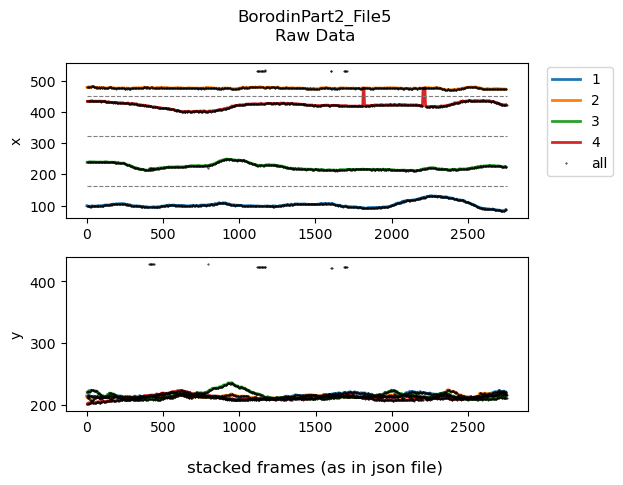

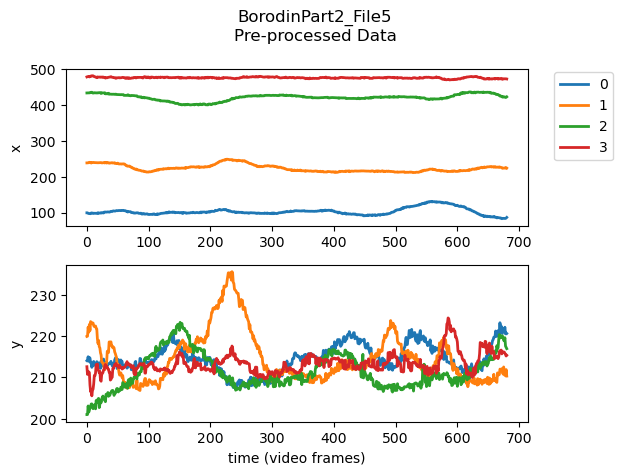


BorodinPart3_File2


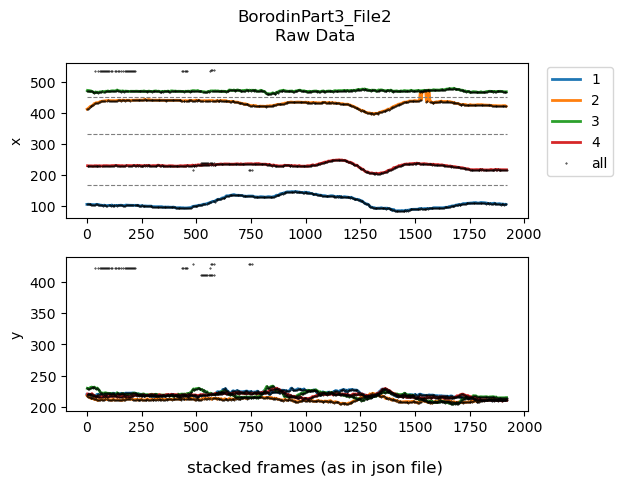

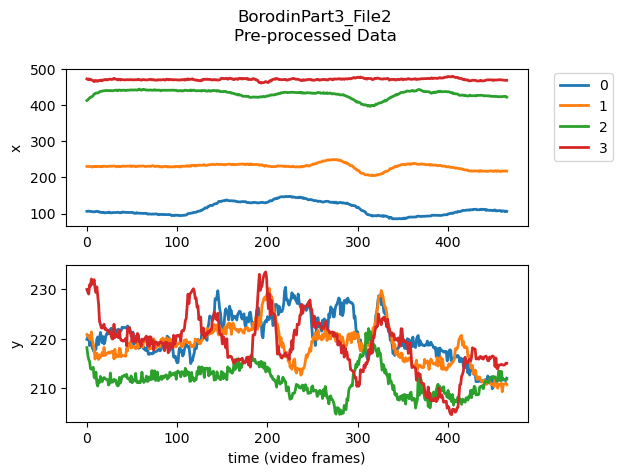

In [229]:
series_labels = ['x','y']
if len(series_selection) > 2:
    raise Exception(''.join(['only one point with two dimensions (x,y) allowed, ',
                             f'but instead got this: {series_selection}']))

if isinstance(disran_dim,int): disran_dim = [disran_dim]
elif isinstance(disran_dim,str): disran_dim = list(range(len(series_labels)))

if not overwrite_results: json_saved_fn = listdir(json_path)
persons_range = range(1,n_persons+1)
series_range = range(n_series)

for fn in fn_lst:

    fn_ne = fn.split('.')[0]
    if verbose: print('\n'+fn_ne)
    
    new_file = True
    if not overwrite_results:
        json_fn = f'alphapose-results_{fn_ne}.json'
        new_file = json_fn not in json_saved_fn

    if overwrite_results or new_file:
    
        # Load data from JSON file produced by AlphaPose:
        json_fn = f'alphapose-results_{fn_ne}.json'
        data_raw_df = pd.read_json(json_path + '\\' + json_fn)
    
        # Reduce by removing unnecessary data:
        data_red_df = data_raw_df.drop(['category_id','keypoints','score','box'],axis=1)
        for lbl,i in zip(series_labels,series_selection):
            data_red_df[lbl] = data_raw_df.keypoints.str[i]
        data_red_df.image_id = data_red_df.image_id.str.split('.').str[0].astype(int)
    
        # Inspect and make plot of raw data:
        if disran_dim: limits = []
        if verbose or save_raw_fig or save_pp_log or disran_dim:
            if save_pp_log: pp_log_txt = [fn_ne + '\n']
            if t_range == 'all':
                t_range = [0,data_red_df.image_id.max()]
            n_series = len(series_selection)
            if verbose or save_raw_fig or save_pp_log or disran_dim:
                for i_s in series_range:
                    if verbose or save_raw_fig: plt.subplot(n_series,1,i_s+1)
                    n_frames = []
                    legend = []
                    for i_p in persons_range:
                        data_red_slice_df =\
                            data_red_df[series_labels[i_s]][  (data_red_df.idx == i_p) 
                                                            & (data_red_df.image_id >= t_range[0]) 
                                                            & (data_red_df.image_id < t_range[1]) ]
                        if verbose or save_raw_fig: 
                            data_red_slice_df.plot(linewidth=linewidth)
                        n_frames.append(len(data_red_slice_df))

                    if verbose or save_raw_fig or disran_dim:
                        this_series = data_red_df[series_labels[i_s]].sort_values()
                    if verbose or save_raw_fig:
                        this_series.plot( marker='.', linestyle='none', markersize=markersize, color='k')
                        
                    plot_hlines = False
                    if disran_dim and (i_s in disran_dim):
                        mcs = int(len(this_series)/(n_persons*2))
                        clustering = HDBSCAN( min_cluster_size=mcs, store_centers="centroid",
                                              metric="cityblock" )
                        clustering.fit(np.reshape(this_series, (-1, 1)))
                        centroids = np.squeeze(clustering.centroids_)
                        if centroids.size == n_persons:
                            these_limits = centroids[:-1] + np.diff(centroids)/2
                            these_limits = np.insert( these_limits, [0,len(centroids)-1], 
                                                      [0,this_series.max()] )
                            limits.append(these_limits)
                            plot_hlines = True
                        else:
                            limits.append(None)
                            print(f'Warning: no disjoint ranges for axis {i_s} ({series_labels[i_s]})')
    
                        if plot_hlines: plt.hlines( these_limits[1:-1], 0, len(this_series),
                                                    linestyles='dashed', 
                                                    colors='tab:gray', linewidths=0.8 )
    
                    plt.ylabel(series_labels[i_s])
                    if i_s == 0: 
                        plt.legend( list(persons_range)+['all'],loc='upper right', 
                                    bbox_to_anchor=(1.2, 1.02) )

                if save_pp_log: 
                    mean_persons = sum(n_frames)/n_persons
                    for p in n_frames:
                        if p != mean_persons:
                            warning_frames = ''.join([ 'inconsistent frame count in ,'
                                                      f'{series_labels[i_s]} {tuple(n_frames)}' ])
                            pp_log_txt.append( warning_frames+'\n' )
                            if verbose: print('Warning:',warning_frames)
                            break

            if verbose or save_raw_fig:
                plt.gcf().suptitle(fn_ne+'\nRaw Data')
                plt.gcf().supxlabel('stacked frames (as in json file)')
                plt.tight_layout()
                fig_ffn = figures_path + '\\' + fn_ne + '_RAW.png'
                plt.savefig(fig_ffn)
                if verbose: plt.show()
            if (not verbose) or (save_raw_fig == 'concealed'): plt.close(plt.gcf())
            if save_pp_log or verbose:
                if (data_red_df.idx.max()) != n_persons:
                        warning_idx = 'more idx than number of people in raw data'
                        if verbose: print('Warning:',warning_idx)
                        if save_pp_log: pp_log_txt.append(warning_idx+'\n')

        # Rearrange such that each row is a frame (image_id):
        data_rar_df = pd.DataFrame( list(range(data_red_df.image_id.max() + 1)) , columns=['image_id'])
        for i_p in persons_range:
            data_rar_df = data_rar_df.merge( 
                data_red_df[['image_id']+series_labels][(data_red_df.idx == i_p)],
                on='image_id', how='left', suffixes=(f'_{i_p-1}',f'_{i_p}') )
        data_rar_df = data_rar_df.drop(['image_id'],axis=1)
        
        # Re-order and re-label columns in order from left to right as they appear in the image:
        # It is assumed that the persons don't relocate (e.g. they are sitting or standing in one place).
        # Indices are set to start at 0 to be consistent with Python indexing.
        new_order_x = [ x for x in data_rar_df.iloc[:,::2].median().sort_values().index]
        new_order_y = [ y.replace(series_labels[0],series_labels[1]) for y in new_order_x ]
        new_order_xy = []
        new_order_lbl = []
        i_c = 0
        for x,y in zip(new_order_x,new_order_y):
            new_order_xy.append(x)
            new_order_xy.append(y)
            new_order_lbl.append(f'{i_c}_{series_labels[0]}')
            new_order_lbl.append(f'{i_c}_{series_labels[1]}')
            i_c += 1
        data_rar_df = data_rar_df.reindex(new_order_xy, axis=1)
        data_rar_df.columns = new_order_lbl

        # Apply disjoint ranges:
        if disran_dim:
            i_lims = 0
            for d in disran_dim: 
                if isinstance(limits[i_lims],np.ndarray):
                    i_col = 0
                    for col_lbl in data_rar_df:
                        if (col_lbl[ col_lbl.index('_')+1: ]) == series_labels[d]:
                            lim_lo = data_rar_df[col_lbl] > limits[i_lims][i_col]
                            lim_hi = data_rar_df[col_lbl] <= limits[i_lims][i_col+1]
                            mask = lim_lo & lim_hi
                            data_rar_df[col_lbl] = data_rar_df.loc[mask,col_lbl]
                            i_col += 1
                i_lims += 1

        # Fill missing data:
        found_nan = data_rar_df.isnull().values.any()
        if found_nan:
            data_rar_df = data_rar_df.interpolate(limit_direction='both',method='cubicspline')
            if save_pp_log or verbose:
                warning_interp = 'missing raw data have been interpolated'
                if verbose: 
                    print('Warning:',warning_interp)
                if save_pp_log: 
                    pp_log_txt.append(warning_interp+'\n')
    
        # Save preprocessing log:
        if save_pp_log:
            txtlog_ffn = logs_path + '\\' + 'pp_log.txt'
            pp_log_txt.append('\n')
            with open(txtlog_ffn, 'a') as output:
                for t in pp_log_txt:
                    output.write(t)
    
        # Make plot of pre-processed data:
        if verbose or save_pp_fig:
            if t_range == 'all':
                t_range = [0,data_rar_df.index.max()]
            for i_s in series_range:
                plt.subplot(n_series,1,i_s+1)
                legend = []
                names_cols = [ f'{n}_{series_labels[i_s]}' for n in range(n_persons)]
                for nc in names_cols:
                    data_rar_slice_df = data_rar_df[nc].iloc[ t_range[0] : t_range[1] ]
                    data_rar_slice_df.plot(linewidth=linewidth)

                    legend.append(nc.split('_')[0])
                    n_frames.append(len(data_red_slice_df))
                plt.ylabel(series_labels[i_s])
                if i_s == 0: 
                    plt.legend(legend,loc='upper right', bbox_to_anchor=(1.2, 1.02))
            plt.suptitle(fn_ne+'\nPre-processed Data')
            plt.xlabel('time (video frames)')
            plt.tight_layout()
            fig_ffn = figures_path + '\\' + fn_ne + '_PP.png'
            plt.savefig(fig_ffn)
            if verbose: plt.show()
            if (not verbose) or (save_pp_fig == 'concealed'): plt.close(plt.gcf())

    # Write pre-processed data to a file:
    if save_parquet:    
        AP_pp_ffn = preproc_path + '\\' + fn_ne + '.parquet'
        data_rar_df.to_parquet(AP_pp_ffn)